# Project 2 - Continual Learning (CL) for Robotic Perception

This notebook is developed by Akshat Khare(ak7674@nyu.edu) and Dhaval Patel(djp526@nyu.edu). 

# Overview of Notebook


Model 1) ANN Model base on https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
  

> Task 1: Train and Test on Dataset --> mnist_rotations.pt <br> Task 2: Train and Test on Dataset --> Simple MNIST <br>
Task 3: Train and Test on Dataset --> (mnist_rotations.pt + Simple MNIST) with out Random Sampling <br>
Task 4: Train and Test on Dataset --> (mnist_rotations.pt + Simple MNIST) with Random Sampling <br> 


Model 2) ANN Model With DropOut suggested by ref research paper https://arxiv.org/pdf/1703.04200.pdf 

> Task 1: Train and Test on Dataset --> mnist_rotations.pt <br> Task 2: Train and Test on Dataset --> Simple MNIST <br>
Task 3: Train and Test on Dataset --> (mnist_rotations.pt + Simple MNIST) with out Random Sampling <br>
Task 4: Train and Test on Dataset --> (mnist_rotations.pt + Simple MNIST) with Random Sampling <br> 

Note: Task 1, 2 are Ordinary Learning Methods and Task 3, 4 are Continual Learning Methods


# Introduction

In this notebook we study the problem of continual learning, where the model observes examples concerning a sequence of tasks. First, we propose a set of metrics to evaluate models learning over a continuum of data. These metrics characterize models not only by their test accuracy, but also in terms of their ability to transfer knowledge across tasks. Second, we propose a model which is trained on the rotated MNIST data, then we run it on Simple MNIST to show Catastrophic Forgetting. After that we proporse a strategy(Rehearsal Strategy) that alleviates forgetting, by randomly mixing data from current task and previous tasks. Futhermore, we have also used a different model of neural networks to further improve the results. 

# Importing the data

First of all we begin with importing the drive where roated MNIST dataset is located.

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# path for Dataset
cd 'drive/My Drive/NYU Sem 2/AI/Project 2'


[Errno 2] No such file or directory: 'drive/My Drive/NYU Sem 2/AI/Project 2'
/content/drive/My Drive/NYU Sem 2/AI/Project 2


In [0]:
!ls

'Copy of Untitled.ipynb'   mnist_rotations.pt	   PATH_TO_STORE_TRAINSET
 mnist_permutations.pt	   PATH_TO_STORE_TESTSET


Follow the steps mentioed in the Comments to produce the dataset mnist_rotations.pt

In [0]:
# Load the dataset mentioned on https://pantelis.github.io/cs-gy-6613-spring-2020/docs/projects/continuous-learning/ for Rotated MNIST Option

# Step 1: Download the github repositary: https://github.com/facebookresearch/GradientEpisodicMemory
# Step 2: run the run_experiments.sh file to download the mnist_permutations.pt and mnist_rotations.pt dataset
import torch
import torchvision

# Time to load the dataset in our notebook
datasetmnistRotation=torch.load('./mnist_rotations.pt')

From the datasetmnistRotation dataset we extract data of a specific rotation angle which is given in putRotationDegree. <br>The input features are stored in dataset_input and output labels are stored in dataset_label. <br>We split the data into testing and training data by using sklearns train_test_split function. 



Now, we split the rotated MNIST data into test and train:

In [129]:
# Select Rotation Degree
putRotationDegree=8 

dataset_input = datasetmnistRotation[0][putRotationDegree][1].reshape(60000,28,28)
dataset_label = datasetmnistRotation[0][putRotationDegree][2]
print(dataset_input.shape,dataset_label.shape)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(dataset_input,dataset_label,test_size=0.20,stratify=dataset_label)

torch.Size([60000, 28, 28]) torch.Size([60000])


Divide the data into batch size of 100 for future training.

In [0]:
# Ref: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

trainDatasetMNISTRotation = []
for i in range(len(x_train)):
   trainDatasetMNISTRotation.append([x_train[i], y_train[i]])

testDatasetMNISTRotation = []
for i in range(len(x_test)):
   testDatasetMNISTRotation.append([x_test[i], y_test[i]])

trainloaderMNISTRotation=torch.utils.data.DataLoader(trainDatasetMNISTRotation, batch_size=100)
testloaderMNISTRotation=torch.utils.data.DataLoader(testDatasetMNISTRotation, batch_size=100) 


Now, we will be doing some exploratory data analysis on our images and tensors. Let us check out the shape of the images and the labels.


# Exploring data


In this phase, we check the shape of the dataset and plot few images to check data consistency.


In [131]:
dataiter = iter(trainloaderMNISTRotation)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([100, 28, 28])
torch.Size([100])


The shape of images as you’ll find out is, torch.Size([100,1,28,28]), which suggests that there are 64 images in each batch and each image has a dimension of 28 x 28 pixels. Similarly, the labels have a shape as torch.Size([100]) as 100 images have 100 labels respectively.

Below code with generate a grid of (5,4) image for the first 20 image.


tensor([8, 4, 0, 3, 8, 9, 8, 3, 4, 3, 6, 8, 0, 7, 0, 0, 2, 7, 3, 3])


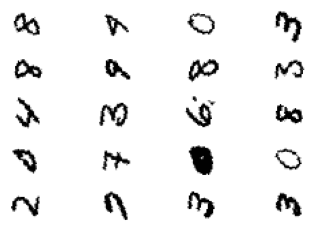

In [132]:
import matplotlib.pyplot as plt
import numpy as np

checkImages=20
images = x_train[:checkImages]
figure = plt.figure()
# Display first 20 image from the 1st bathc
for index in range(checkImages):
    plt.subplot(5, 4, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Output lables of the particular image
print(y_train[:checkImages])

# Building the model

Building The Neural Network:

We will be building the following network, as you can see it contains an input layer (the first layer), an output layer of ten neurons (or units, the circles) and two hidden layers in between.

The neural network iterates over the training set and updates the weights. We make use of torch.optim which is a module provided by PyTorch to optimize the model, perform gradient descent and update the weights by back-propagation. Thus in each epoch (number of times we iterate over the training set), we will be seeing a gradual decrease in training loss.

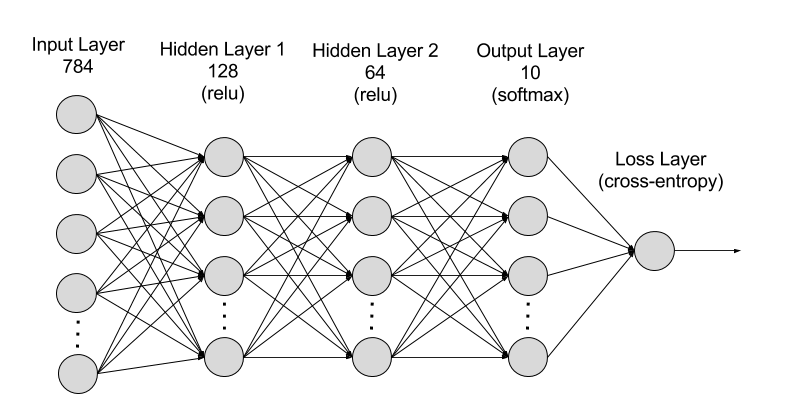![alt text](https://)

The neural network iterates over the training set and updates the weights. We make use of torch.optim which is a module provided by PyTorch to optimize the model, perform gradient descent and update the weights by back-propagation. Thus in each epoch (number of times we iterate over the training set), we will be seeing a gradual decrease in training loss.

In [133]:
# Model Ref: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

from time import time
from torchvision import datasets, transforms
from torch import nn, optim

input_size = 784 #28*28
hidden_sizes = [128, 64] # 2 layers
output_size = 10 #for 10 digits

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


The nn.Sequential wraps the layers in the network. There are three linear layers with ReLU activation ( a simple function which allows positive values to pass through, whereas negative values are modified to zero ). The output layer is a linear layer with LogSoftmax activation because this is a classification problem.

Technically, a LogSoftmax function is the logarithm of a Softmax function as the name says and it looks like this, as shown below.

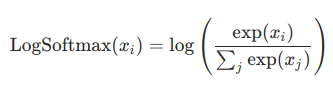

Next, we define the negative log-likelihood loss. It is useful to train a classification problem with C classes. Together the LogSoftmax() and NLLLoss() acts as the cross-entropy loss as shown in the network architecture diagram above.

Also, you must be wondering why do we have 784 units in the first layer. Good! It is because we flatten out each image before sending it inside the neural network. (28 x 28 = 784)

# Training the model

This is where we train the model. We have created a function to train the model which will be useful in future. The neural network iterates over the training set and updates the weights. In each epoch (number of times we iterate over the training set), we will be seeing a gradual decrease in training loss. 

In [0]:
def traingModel(putTrainDataSet,epochs):
  optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
  time0 = time()
  criterion = nn.NLLLoss()
  for e in range(epochs):
      running_loss = 0
      for images, labels in putTrainDataSet:
          # Flatten MNIST images into a 784 long vector
          images = images.view(images.shape[0], -1)
      
          # Training pass
          optimizer.zero_grad()
          
          output = model(images)
          loss = criterion(output, labels)
          
          #This is where the model learns by backpropagating
          loss.backward()
          
          #And optimizes its weights here
          optimizer.step()
          
          running_loss += loss.item()
      else:
          print("Epoch {} - Training loss: {}".format(e, running_loss/len(putTrainDataSet)))
  print("\nTraining Time (in minutes) =",(time()-time0)/60)
  return

Before the backward pass, the model weights are set to default none values. Once, we call the backward() function the weights are updated.

After writing the function we train the model from MNIST Rotation dataset:

In [135]:
# Train model for MNIST Rotation dataset
traingModel(trainloaderMNISTRotation,15)

Epoch 0 - Training loss: 1.441074891326328
Epoch 1 - Training loss: 0.4313741881089906
Epoch 2 - Training loss: 0.34264221439758935
Epoch 3 - Training loss: 0.30343448168908554
Epoch 4 - Training loss: 0.27431080280803144
Epoch 5 - Training loss: 0.24934976117995877
Epoch 6 - Training loss: 0.2276174660772085
Epoch 7 - Training loss: 0.2087438707239926
Epoch 8 - Training loss: 0.1924598551976184
Epoch 9 - Training loss: 0.17807633706834167
Epoch 10 - Training loss: 0.1652663910916696
Epoch 11 - Training loss: 0.15386292714780817
Epoch 12 - Training loss: 0.14369436711228142
Epoch 13 - Training loss: 0.13457932949919874
Epoch 14 - Training loss: 0.1263838526676409

Training Time (in minutes) = 0.29304620027542116


# Testing Phase

## Testing on Rotated MNIST

The model is ready, but we have to evaluate it first. We created a utility function view_classify() to show the image and class probabilities that were predicted. (Reference Link: https://github.com/amitrajitbose/handwritten-digit-recognition)

We passed an image to the trained model from the validation set that we created earlier, to see how the model works.

In [0]:
# Ref: https://github.com/amitrajitbose/handwritten-digit-recognition
def displayImageAndProability(img, ps, version="MNIST"):
  ps = ps.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
  ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
  ax1.axis('off')
  ax2.barh(np.arange(10), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(10))
  ax2.set_yticklabels(np.arange(10))
  ax2.set_title('Class Probability')
  ax2.set_xlim(0, 1.1)
  return 

Predicted Digit = 6


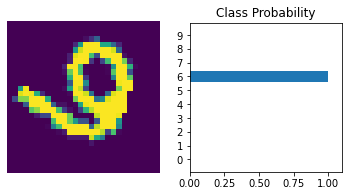

In [137]:
images, labels = next(iter(testloaderMNISTRotation))

img = images[0].view(1, 784)
with torch.no_grad():
  logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))

# Call the function to display any image and it's predictions
displayImageAndProability(img.view(1, 28, 28), ps)

As we can see from the above result, the rotated image of on left side is corretly predicted by our model on right side.

Now we iterate through the validation set using a for loop and calculate the total number of correct predictions. <br> Belows code show the accuracy calculations.

In [0]:
def testAndGetAccuracy(testDataset):
  correct_count, all_count = 0, 0
  for images,labels in iter(testDataset):
    for i in range(len(labels)):
      img = images[i].view(1, 784)
      with torch.no_grad():
          logps = model(img)

      ps = torch.exp(logps)
      probab = list(ps.numpy()[0])
      pred_label = probab.index(max(probab))
      true_label = labels.numpy()[i]
      if(true_label == pred_label):
        correct_count += 1
      all_count += 1
  print("\nNumber Of Images Tested =", all_count)
  print("Model Accuracy =", (correct_count/all_count))
  return

### Result:

In [139]:
# Check Accuracy of MNIST Rotation dataset
testAndGetAccuracy(testloaderMNISTRotation)


Number Of Images Tested = 12000
Model Accuracy = 0.9548333333333333


We got almost 95% accuracy. The reason we got such a high accuracy was that our data-set was clean, had a variety of well-shuffled images and a large number of them. This made our model well prepared to recognize a large number of unseen digits.

## Testing on Simple MNIST Test Dataset


Now that our model is ready, we will train the model on different datasets and then we will test the model on all test datasets.

Firstly, we will run the model trained on Rotated MNIST on Simple MNIST, the results are expected to be bad. 

First we load the simple MNIST data:

In [0]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor()])

trainDatasetSimpleMNIST=datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True,transform=transform)
testDatasetSimpleMNIST=datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False,transform=transform)

trainloaderSimpleMNIST=torch.utils.data.DataLoader(trainDatasetSimpleMNIST, batch_size=100)
testloaderSimpleMNIST=torch.utils.data.DataLoader(testDatasetSimpleMNIST, batch_size=100)


### Result of Rotated MNIST on Simple MNIST

In [141]:
testAndGetAccuracy(testloaderSimpleMNIST)


Number Of Images Tested = 10000
Model Accuracy = 0.1636


As expected, the accuracy on Simple MNIST dataset is pretty bad, this shows that our algorithm is suffering from Catastrophic Forgetting. As when the data changes a little our model fails to identify the correct result.

Now, we train the model on Simple MNIST dataset

In [142]:
# Train model for Simple MNIST dataset
traingModel(trainloaderSimpleMNIST,15)

Epoch 0 - Training loss: 0.48938276696950195
Epoch 1 - Training loss: 0.2379681344454487
Epoch 2 - Training loss: 0.1945326205001523
Epoch 3 - Training loss: 0.1682718244738256
Epoch 4 - Training loss: 0.1495426819100976
Epoch 5 - Training loss: 0.13483643205836415
Epoch 6 - Training loss: 0.12293625558105607
Epoch 7 - Training loss: 0.11305016663856804
Epoch 8 - Training loss: 0.1045602598786354
Epoch 9 - Training loss: 0.09725135619131227
Epoch 10 - Training loss: 0.09087466777379935
Epoch 11 - Training loss: 0.08524486238292107
Epoch 12 - Training loss: 0.08017400803044439
Epoch 13 - Training loss: 0.07556477724652116
Epoch 14 - Training loss: 0.07142091755988077

Training Time (in minutes) = 1.5039060513178508


In [143]:
# Check Accuracy of Simple MNIST dataset
testAndGetAccuracy(testloaderSimpleMNIST)


Number Of Images Tested = 10000
Model Accuracy = 0.972


The accuracy of model trained on simple MNIST is expected to work well on test data of Simple MNIST. But, when we test it on Rotated MNIST, the results will be devastating as shown below.

### Result of simple MNIST on Rotated MNIST

In [144]:
testAndGetAccuracy(testloaderMNISTRotation)


Number Of Images Tested = 12000
Model Accuracy = 0.33375


# CL strategy

To solve the problem of **Catastrophic Forgetting**, we have implemented a Rehearsal Strategy for learning continually and trying not to forget. Firstly, we have trained the model on the complete dataset to see the results. In Rehearsal Strategy we take randomly selected values from both the datasets( Rotated MNIST and Simple MNIST) and then we merge them to form our training dataset which we will use to train the model. Then we will test the model on test datasets of both Rotated MNIST and Simple MNIST to see if we have handled the Catastrophic Forgetting problem. 

## Implementation of Rehearsal Strategy

Firstly, we have trained the model on the complete dataset to see the results.

Merging the dataset:

In [0]:
mergeTrainingDataset=torch.utils.data.ConcatDataset((trainDatasetMNISTRotation,trainDatasetSimpleMNIST))
mergeloaderDataset=torch.utils.data.DataLoader(mergeTrainingDataset, batch_size=100)


Training the dataset: 

In [146]:
# Training with out Dropping Data Rows
traingModel(mergeloaderDataset,15)


Epoch 0 - Training loss: 0.18593256208114325
Epoch 1 - Training loss: 0.14034958935635924
Epoch 2 - Training loss: 0.12437836667436554
Epoch 3 - Training loss: 0.11328064210247249
Epoch 4 - Training loss: 0.10477981125220173
Epoch 5 - Training loss: 0.09768445233090056
Epoch 6 - Training loss: 0.0916434140668975
Epoch 7 - Training loss: 0.08635813700104202
Epoch 8 - Training loss: 0.08153188756399754
Epoch 9 - Training loss: 0.07726684168662393
Epoch 10 - Training loss: 0.07330137946108287
Epoch 11 - Training loss: 0.06965234199500021
Epoch 12 - Training loss: 0.06628975203278026
Epoch 13 - Training loss: 0.06313673281563549
Epoch 14 - Training loss: 0.06017745904499423

Training Time (in minutes) = 1.843388517697652


In [147]:
testAndGetAccuracy(testloaderMNISTRotation)

testAndGetAccuracy(testloaderSimpleMNIST)



Number Of Images Tested = 12000
Model Accuracy = 0.9033333333333333

Number Of Images Tested = 10000
Model Accuracy = 0.9736


As expected, good accuracy on both the datasets, but this computation is expensive as training is done on huge amount of dataset. To make this computation better, we randomly pick data from both the datatsets and merge them to make the training dataset smaller and computation faster. 

To make the training dataset smaller we further split the training dataset into test train and then merge the new further splitted training data together to form a smaller training dataset.

Splitting Rotated MNIST training dataset:

In [0]:
R_train,R_test,Q_train,Q_test=train_test_split(x_train,y_train,test_size=0.25,stratify=y_train)
shuffledTrainDatasetMNISTRotation = []
for i in range(len(R_train)):
   shuffledTrainDatasetMNISTRotation.append([R_train[i], Q_train[i]])

Splitting Simple MNIST training dataset:

In [0]:
lengths = [int(len(trainDatasetSimpleMNIST)*0.8), int(len(trainDatasetSimpleMNIST)*0.2)]
shuffledTrainDatasetSimpleMNIST, discarded_data = torch.utils.data.random_split(trainDatasetSimpleMNIST, lengths)

Merging both the datasets together:

In [0]:
shuffledMergeTrainingDataset=torch.utils.data.ConcatDataset((shuffledTrainDatasetMNISTRotation,shuffledTrainDatasetSimpleMNIST))
shuffledMergeloaderDataset=torch.utils.data.DataLoader(shuffledMergeTrainingDataset, batch_size=100)


Training the model on smaller dataset:

In [151]:
traingModel(shuffledMergeloaderDataset,15)

Epoch 0 - Training loss: 0.06095123217064178
Epoch 1 - Training loss: 0.05638638323621958
Epoch 2 - Training loss: 0.053041765432793736
Epoch 3 - Training loss: 0.05008674872279655
Epoch 4 - Training loss: 0.04742674543744042
Epoch 5 - Training loss: 0.04498229693854228
Epoch 6 - Training loss: 0.04268197536917536
Epoch 7 - Training loss: 0.04051768265725557
Epoch 8 - Training loss: 0.038498615314407895
Epoch 9 - Training loss: 0.036595247044793465
Epoch 10 - Training loss: 0.034806951366564524
Epoch 11 - Training loss: 0.03307283682987049
Epoch 12 - Training loss: 0.03146376356127716
Epoch 13 - Training loss: 0.029905184090880322
Epoch 14 - Training loss: 0.028428798609335598

Training Time (in minutes) = 1.4712916215260823


Testing accuracy:

In [152]:
testAndGetAccuracy(testloaderMNISTRotation)
                   
testAndGetAccuracy(testloaderSimpleMNIST)


Number Of Images Tested = 12000
Model Accuracy = 0.93775

Number Of Images Tested = 10000
Model Accuracy = 0.9728


This gives us decent results in a shorter computation time.

# Testing on a different Model (Model 2)

Now, Let's try a different neural network model to see if we can improve our result. <br>As suggested in the research paper (https://arxiv.org/pdf/1703.04200.pdf), we have added two dropout layers in the neural network. <br>Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. <br>Dropout layers are a Simple Way to Prevent Neural Networks from Overfitting. 

Now we will train this model and see the results. 

Building the model:

In [153]:
# Model Ref: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
# Updated the neural network model with Dropout suggested on this ref research paper https://arxiv.org/pdf/1703.04200.pdf
# Understanding Dropout Implementation in PyTorch: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.Dropout(0.5), #50 % probability 
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Dropout(0.2), #20 % probability 
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax()
)


Training and testing the model on MNIST Rotation dataset:

In [155]:
# Task 1
traingModel(trainloaderMNISTRotation,15)
testAndGetAccuracy(testloaderMNISTRotation)


Epoch 0 - Training loss: 0.22671272467511397
Epoch 1 - Training loss: 0.2181748393146942
Epoch 2 - Training loss: 0.21151038128882646
Epoch 3 - Training loss: 0.20675783775125942
Epoch 4 - Training loss: 0.20402124338628103
Epoch 5 - Training loss: 0.19660818608632932
Epoch 6 - Training loss: 0.19008995248004795
Epoch 7 - Training loss: 0.18931036756063502
Epoch 8 - Training loss: 0.18794231604939948
Epoch 9 - Training loss: 0.17586622467885415
Epoch 10 - Training loss: 0.17933443121922513
Epoch 11 - Training loss: 0.17436589338661482
Epoch 12 - Training loss: 0.16900884817975262
Epoch 13 - Training loss: 0.1679549578887721
Epoch 14 - Training loss: 0.16406687217143676

Training Time (in minutes) = 0.3294136921564738

Number Of Images Tested = 12000
Model Accuracy = 0.9425833333333333


Testing model(trained on Rotated MNIST) on Simple MNIST:

In [156]:
testAndGetAccuracy(testloaderSimpleMNIST)


Number Of Images Tested = 10000
Model Accuracy = 0.1592


Training and testing the model on Simple MNIST dataset:

In [157]:
# Task 2
traingModel(trainloaderSimpleMNIST,15)
testAndGetAccuracy(testloaderSimpleMNIST)

Epoch 0 - Training loss: 0.8302484306196372
Epoch 1 - Training loss: 0.4273244561503331
Epoch 2 - Training loss: 0.36054254504541555
Epoch 3 - Training loss: 0.3239213877171278
Epoch 4 - Training loss: 0.29643611310670775
Epoch 5 - Training loss: 0.28120622692629693
Epoch 6 - Training loss: 0.26337365050489703
Epoch 7 - Training loss: 0.25307591702168186
Epoch 8 - Training loss: 0.24760298223545155
Epoch 9 - Training loss: 0.2339209395709137
Epoch 10 - Training loss: 0.2268177292868495
Epoch 11 - Training loss: 0.21863620845600962
Epoch 12 - Training loss: 0.2099245744943619
Epoch 13 - Training loss: 0.2036819482470552
Epoch 14 - Training loss: 0.2011159922927618

Training Time (in minutes) = 1.6059470097223918

Number Of Images Tested = 10000
Model Accuracy = 0.9353


Testing simple MNIST model on Rotated MNIST:

In [158]:
testAndGetAccuracy(testloaderMNISTRotation)


Number Of Images Tested = 12000
Model Accuracy = 0.2920833333333333


Merging two datasets and testing accuracy on both datasts:

In [159]:
# Task 3
traingModel(mergeloaderDataset,15)
testAndGetAccuracy(testloaderMNISTRotation)
testAndGetAccuracy(testloaderSimpleMNIST)

Epoch 0 - Training loss: 0.40249633516564415
Epoch 1 - Training loss: 0.3199464196304756
Epoch 2 - Training loss: 0.2979083037969691
Epoch 3 - Training loss: 0.2870431558470483
Epoch 4 - Training loss: 0.2765398939864503
Epoch 5 - Training loss: 0.26583627345799293
Epoch 6 - Training loss: 0.26078971962065056
Epoch 7 - Training loss: 0.2536933980088819
Epoch 8 - Training loss: 0.2488930467085016
Epoch 9 - Training loss: 0.24898386374115944
Epoch 10 - Training loss: 0.2414815119571156
Epoch 11 - Training loss: 0.24012242556998023
Epoch 12 - Training loss: 0.2348624269167582
Epoch 13 - Training loss: 0.2300434280152398
Epoch 14 - Training loss: 0.2292797149228001

Training Time (in minutes) = 1.9974993268648784

Number Of Images Tested = 12000
Model Accuracy = 0.8125833333333333

Number Of Images Tested = 10000
Model Accuracy = 0.9313


Randomly selecting parts of both datasets and testing accuracy:

In [160]:
# Task 4
traingModel(shuffledMergeloaderDataset,15)
testAndGetAccuracy(testloaderMNISTRotation)
testAndGetAccuracy(testloaderSimpleMNIST)

Epoch 0 - Training loss: 0.23137230311653445
Epoch 1 - Training loss: 0.2242835967446722
Epoch 2 - Training loss: 0.2227490935785075
Epoch 3 - Training loss: 0.2241496026161171
Epoch 4 - Training loss: 0.21782651428310645
Epoch 5 - Training loss: 0.21524347590193862
Epoch 6 - Training loss: 0.2157621046572569
Epoch 7 - Training loss: 0.21405023346610721
Epoch 8 - Training loss: 0.21064215842190953
Epoch 9 - Training loss: 0.20711049608708848
Epoch 10 - Training loss: 0.20477369297295808
Epoch 11 - Training loss: 0.20396443160605573
Epoch 12 - Training loss: 0.20122299732729082
Epoch 13 - Training loss: 0.20090123998178613
Epoch 14 - Training loss: 0.1988264716496425

Training Time (in minutes) = 1.5640065789222717

Number Of Images Tested = 12000
Model Accuracy = 0.86775

Number Of Images Tested = 10000
Model Accuracy = 0.9363


Thus we can see that we have further increased the accuracy by implementing a better neural network model.  

# Results


**Results of Model 1:**
1. On running a model (trained on Simple MNIST dataset) on Rotated MNIST test dataset we get an accuracy of **33%**
2. On running a model(trained on Rotated MNIST dataset) on Simple MNIST test dataset we get an accuracy of **16%**.
3. After merging both the datasets we get **91%** accuracy for test Rotated MNIST dataset and **97%** accuracy for test Simple MNIST dataset.
4. After merging random parts of both training datasets we get **93%** and **97%** accuracy respectively for test datasets of Rotated MNSIT and Simple MNIST.

**Results of Model 2:**

1. On running model2 (trained on Simple MNIST dataset) on Rotated MNIST test dataset we get an accuracy of **30%**
2. On running a model2 (trained on Rotated MNIST dataset) on Simple MNIST test dataset we get an accuracy of **16%**
3. After merging both the datasets we get **81%** accuracy for test Rotated MNIST dataset and **93%** accuracy for test Simple MNIST test dataset.
4. After merging random parts of both training datasets we get **87%** and **93%** accuracy respectively for test datasets of Rotated MNSIT and Simple MNIST.






# Conclusions

* In this notebook we show that the problem of catastrophic forgetting commonly encountered in continual learning scenarios can be alleviated by allowing individual synapses to estimate their importance for solving past tasks.
<br>
* **Using Rehearsal Strategy** and a good neural network model we are able to get good efficiency. The Rehearsal Strategy uses repeated practice of information to train the model. The advantage of Rehearsal strategy is faster computation time. 
<br>
* Further addition of **dropout layers in neural network** model improved the accuracy significantly. Although we feel that we achieved a good accuracy but to further improve the accuracy we can also use more complex strategies like **GEM** to improve the model.
* By allocating more computation time by **increasing the epochs**, Model would be able to classify object more correclty but we also consider **overfitting** in case the model is been trained for the large amount of time.
